In [1]:
import xarray as xr
import climtas.io
import dask
import numpy as np
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
import dask.distributed
import tempfile
tempdir = tempfile.TemporaryDirectory("dask-worker-space")
dask.distributed.Client(local_directory=tempdir.name, memory_limit='16gb')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38573 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38573/status,
Dashboard: http://127.0.0.1:38573/status,Workers: 4
Total threads: 4,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44257,Workers: 4
Dashboard: http://127.0.0.1:38573/status,Total threads: 4
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://10.0.128.164:41343,Total threads: 1
Dashboard: http://10.0.128.164:40763/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:34833,


In [3]:
anom = xr.open_dataarray('/g/data/w40/rl5183/progress_files/anom_prate.nc', chunks={'member':1}).sel(time=slice('1901-9', '2015-12')) # take time slice a few months larger on either side for smoothing

In [4]:
anom

,Array,Chunk
Bytes,52.33 GiB,678.30 MiB
Shape,"(79, 1372, 180, 360)","(1, 1372, 180, 360)"
Count,159 Tasks,79 Chunks
Type,float64,numpy.ndarray


In [5]:
hadisst_ds = xr.open_dataset('/g/data/eg3/jxb548/OBSDATA/hadisstv1.1870_2017.nc')
sst_data = hadisst_ds.sst

In [6]:
# Detrend HadISST data
sst_data_detrend = np.apply_along_axis(func.detrend_2step, 0, sst_data)
sst_detrended = xr.DataArray(sst_data_detrend, coords=sst_data.coords, attrs=sst_data.attrs)

In [7]:
# Nino3.4 index with HadiSSTv1
nino34_region = sst_detrended.sel(latitude=slice(5,-5), longitude=slice(-170,-120))
climatology = nino34_region.sel(time=slice('1950-01','1979-12')).groupby('time.month').mean()
monthly_anomalies = (nino34_region.groupby('time.month')-climatology).mean(dim=['latitude','longitude'])
monthly_anomalies_rolling = monthly_anomalies.rolling(time=5).mean()
sst_std = nino34_region.sel(time=slice('1950-01','1979-12')).std()
nino34_index = monthly_anomalies_rolling.sel(time=slice('1901-11', '2015-10'))/sst_std

In [8]:
# Take the mean over every quarter
quarterly_nino = nino34_index.resample(time='QS-NOV').mean('time')

# Select out NDJ nino34 index
nino_ndj = quarterly_nino.isel(time=slice(0,None,4))

In [9]:
def ensemble_correlation(data, nino):
    
    anom = data
    
    # Smooth with 3-month running mean
    anom_rolling = anom.rolling(time=3).mean().sel(time=slice('1901-11', '2015-10'))
    
    # Take mean over every quarter 
    quarterly_anom = anom_rolling.resample(time='QS-NOV').mean('time')

    # Calculate instantaneous regression 
    quarterly_correlation = func.correlate_nino_by_month(quarterly_anom, nino)
    
    return quarterly_correlation 

In [10]:
correlation_list = []
for m in anom.member:
    correlation_list.append(ensemble_correlation(anom.sel(member=m), nino_ndj))

In [11]:
correlations = xr.concat(correlation_list, dim='member')

In [12]:
correlations 

<xarray.DataArray (member: 79, month: 4, latitude: 180, longitude: 360)>
array([[[[-1.40410217e-01, -1.40108777e-01, -1.40196202e-01, ...,
          -1.39984907e-01, -1.39985099e-01, -1.40272241e-01],
         [-1.53084767e-01, -1.53413707e-01, -1.53824307e-01, ...,
          -1.51919088e-01, -1.52494580e-01, -1.52967731e-01],
         [-1.59832388e-01, -1.61051779e-01, -1.62027051e-01, ...,
          -1.56853891e-01, -1.57608162e-01, -1.58618561e-01],
         ...,
         [ 1.60536116e-02,  1.62888828e-02,  1.56083745e-02, ...,
           1.75272450e-02,  1.69762691e-02,  1.66818225e-02],
         [-5.76195501e-02, -5.69088955e-02, -5.69945957e-02, ...,
          -5.86305740e-02, -5.83899315e-02, -5.80400698e-02],
         [-1.23433007e-01, -1.22704584e-01, -1.22621754e-01, ...,
          -1.25204272e-01, -1.24901939e-01, -1.24084153e-01]],

        [[ 2.44401571e-02,  2.38788559e-02,  2.32023822e-02, ...,
           2.67669661e-02,  2.60190879e-02,  2.50576145e-02],
         [ 6.00466699e-03,  4.85970622e-03,  3.62785571e-03, ...,
           8.90551310e-03,  7.97858298e-03,  6.74889760e-03],
         [-9.58921685e-03, -1.03349156e-02, -1.09008221e-02, ...,
          -5.43416273e-03, -6.60280632e-03, -8.35299782e-03],
...
         [-9.61128739e-03, -9.68452174e-03, -9.43472231e-03, ...,
          -7.73016187e-03, -7.73317932e-03, -8.21753183e-03],
         [-2.43910104e-02, -2.38717140e-02, -2.36784917e-02, ...,
          -2.34557822e-02, -2.38852517e-02, -2.43725777e-02],
         [-4.25654182e-02, -4.27182887e-02, -4.24242646e-02, ...,
          -4.20378265e-02, -4.23735842e-02, -4.26241904e-02]],

        [[-3.38038809e-02, -3.35709078e-02, -3.34488835e-02, ...,
          -3.32123465e-02, -3.35535352e-02, -3.38984366e-02],
         [-8.16092347e-02, -8.09077961e-02, -8.04793765e-02, ...,
          -8.13172144e-02, -8.13264296e-02, -8.16951828e-02],
         [-1.08014056e-01, -1.07195866e-01, -1.06655241e-01, ...,
          -1.07321959e-01, -1.07689714e-01, -1.07947875e-01],
         ...,
         [ 7.37745080e-02,  7.54088275e-02,  7.74414868e-02, ...,
           7.20108705e-02,  7.20483429e-02,  7.26490802e-02],
         [ 1.27875870e-02,  1.40718181e-02,  1.49540303e-02, ...,
           1.18991192e-02,  1.17326329e-02,  1.20266739e-02],
         [-1.39964668e-02, -1.32510182e-02, -1.28173483e-02, ...,
          -1.38609707e-02, -1.43577392e-02, -1.41320596e-02]]]])
Coordinates:
  * member     (member) int64 1 2 3 4 5 6 7 8 9 ... 72 73 74 75 76 77 78 79 80
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float64 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * month      (month) int64 2 5 8 11

In [13]:
# Save as netcdf
correlations.to_netcdf('/g/data/w40/rl5183/20CR/precip/monthly_precip_correlations_all_members.nc')

In [3]:
correlations = xr.open_dataarray('/g/data/w40/rl5183/20CR/precip/monthly_precip_correlations_all_members.nc')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/local/eg3/rl5183/tmp/ipykernel_2448465/2101169726.py:21: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
  plt.savefig('ensemble_mean_corr_prate.jpg', bbox_inches='tight', dpi=300, qu

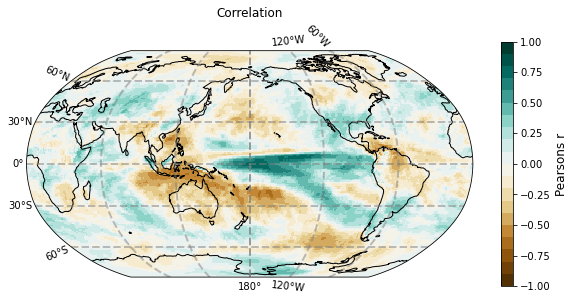

In [4]:
# Plot first member to check 
fig = plt.figure(figsize=(10,5))

vmin=-1
vmax=1

ax = fig.add_subplot(111, projection=ccrs.Robinson(180))
C = correlations.sel(month=11).sel(member=1).plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('BrBG', 20))
ax.coastlines()
ax.set_global()
ax.set_title('Correlation')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
# Colorbar
cbar = plt.colorbar(C, ax=ax, shrink=0.9, pad=0.05)
cbar.ax.set_ylabel('Pearsons r', fontsize=12)

# plt.savefig('ensemble_mean_corr_prate.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

In [16]:
# Calculate standrd deviation between ensemble members
ensemble_std = np.apply_along_axis(np.std, 0, correlations)

In [17]:
# Covert to xarray
ensemble_std = xr.DataArray(ensemble_std, coords=correlations.mean(dim='member').coords)
# Save as netcdf 
ensemble_std.to_netcdf('/g/data/w40/rl5183/20CR/precip/prate_ensemble_std_corr_1901_2015.nc')